# Intro and storytelling

## Introduction to Signature Verification

Imagine signing your name on a document. That simple act holds immense power your signature is a representation of your identity and consent. But what happens when someone tries to mimic it? This is where signature verification comes into play a fascinating blend of human behavior, mathematics, and machine learning.

## The Role of Technology

This challenge opens the door for **automated signature verification systems,** designed to detect forgery with precision and speed. These systems use advanced algorithms and machine learning models to compare signatures against known examples. They don’t just look for surface level similarities but analyze patterns, pressure points, and overall style.

## Why Bidirectional LSTM for signature verification?

**BiLSTM is effective because it processes information in both directions (forward and backward), which helps:**

* **Capture Patterns:** Signatures have strokes and curves that can depend on both earlier and later parts of the signature.
* **Handle Variations:** It can better understand differences between real and forged signatures, even with small variations.
* **Learn Features:** BiLSTM improves accuracy by analyzing global and local features in the signature.

## Bidirectional LSTM Architecture

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*ZsTT3zzTNGF-6OsR.jpg)

# Importing

In [1]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample, shuffle

# load images helper functions

**This code defines three functions (load_images1, load_images2, and load_images3) to load and preprocess images from multiple datasets, helping to generalize the model. Each function processes images by resizing, converting them to grayscale, and assigning labels ('real' or 'forged').**

* **load_images1** loads images from a set of folders with specific types ('real' or 'forged') and plots samples.
* **load_images2** loads images from subfolders, processes them similarly, and also provides samples.
* **load_images3** loads images from subfolders where filenames indicate whether the image is 'real' or 'forged'.

**By using data from multiple sources, the model can generalize better and avoid overfitting, improving its ability to recognize new, unseen images.**

In [2]:
def load_images1(folder_paths, folder_types, target_size=(128, 128), sample_count=5):

    images = []
    labels = []
    all_filenames = []

    for folder_path, folder_type in zip(folder_paths, folder_types):
        label = 1 if folder_type.lower() == 'real' else 0
        print(f"Loading images from: {folder_path}")

        sample_images = []  # Store sample images for plotting
        sample_titles = []  # Store titles for sample images

        for idx, filename in enumerate(os.listdir(folder_path)):
            if filename.endswith(('.jpg', '.png')):
                # Load and resize image
                img_path = os.path.join(folder_path, filename)
                img = load_img(img_path, target_size=target_size)
                img = img_to_array(img)
                img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
                img_array = img / 255.0 
                img_array = np.expand_dims(img_array, axis=-1)

                # Append to sample lists if under sample_count
                if len(sample_images) < sample_count:
                    sample_images.append(img_array)
                    sample_titles.append(f"{folder_type.capitalize()}: {filename}")

                # Append the processed image and label
                images.append(img_array)
                labels.append(label)
                all_filenames.append(img_path)

        # Plot sample images in a grid
        if sample_images:
            fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
            for ax, sample_img, title in zip(axes, sample_images, sample_titles):
                ax.imshow(sample_img.squeeze(), cmap='gray')  # Use `squeeze` to remove the extra dimension
                ax.set_title(title, fontsize=10)
                ax.axis('off')
            plt.tight_layout()
            plt.show()

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    print(f"Total images loaded: {len(images)}")
    return images, labels

In [3]:
def load_images2(folder_path, folder_type, target_size=(128, 128), sample_count=5):
    images = []
    labels = []
    all_filenames = []
    sample_images = []
    sample_labels = []  # Store labels for sample images

    if not os.path.isdir(folder_path):
        print(f"Warning: Folder {folder_path} does not exist.")
        return np.array(images), np.array(labels), all_filenames

    print(f"Loading images from subfolders of: {folder_path}")

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, filename)
                try:
                    # Load and preprocess the image
                    img = load_img(img_path, target_size=target_size)
                    img = img_to_array(img)
                    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
                    img_array = img / 255.0
                    img_array = np.expand_dims(img_array, axis=-1)

                    # Collect sample images for plotting
                    if len(sample_images) < sample_count:
                        sample_images.append(img_array)
                        sample_labels.append('Real' if folder_type.lower() == 'real' else 'Forged')

                    # Append the processed image and label
                    images.append(img_array)
                    labels.append(1 if folder_type.lower() == 'real' else 0)
                    all_filenames.append(img_path)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

    # Plot the first `sample_count` images
    if sample_images:
        fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
        for ax, sample_img, sample_label in zip(axes, sample_images, sample_labels):
            ax.imshow(sample_img.squeeze(), cmap='gray')
            ax.set_title(sample_label, fontsize=10)  # Use label instead of filename
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    print(f"Total images loaded: {len(images)}")
    return np.array(images), np.array(labels), all_filenames


In [11]:
def load_images3(base_folder, target_size=(128, 128), plot_samples=5):
    images = []
    labels = []
    sample_images = []
    sample_labels = []

    # Iterate through all subfolders in the base folder
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):  # Check if it's a folder
            for filename in os.listdir(subfolder_path):
                # Check if the file is an image
                if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                    if filename.lower().startswith('forgeries') or filename.lower().startswith('forge'):
                        label = 0
                    elif filename.lower().startswith('original'):
                        label = 1
                    else:
                        continue  # Skip images without the correct prefix

                    # Load and preprocess the image
                    img_path = os.path.join(subfolder_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
                    img = cv2.resize(img, target_size)  # Resize to the target size
                    img = img / 255.0  # Normalize to range [0, 1]
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale

                    # Append the image and label
                    images.append(img)
                    labels.append(label)

                    # Collect sample images and labels for plotting
                    if len(sample_images) < plot_samples:
                        sample_images.append(img)
                        sample_labels.append("Forged" if label == 1 else "Original")

    # Plot the collected sample images side by side
    if sample_images:
        fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
        for ax, img, lbl in zip(axes, sample_images, sample_labels):
            ax.imshow(img.squeeze(), cmap='gray')  # Remove extra dimensions for grayscale
            ax.set_title(lbl, fontsize=10)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    # Convert lists to NumPy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    return images, labels

# Images Reading

In [4]:
# data one
forged_data_1 = "/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/forge/"
real_data_1 ="/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/real/"
forged_data_2 = "/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2/forge/"
real_data_2 ="/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2/real/"

In [5]:
# data 2
f_data = "/kaggle/input/handwritten-signature-verification/data/data/forged"
r_data = "/kaggle/input/handwritten-signature-verification/data/data/real"

In [6]:
# data 3
base_folder_path = "/kaggle/input/signature-forgery-dataset/Train"  

In [7]:
forged_list = [forged_data_1, forged_data_2]
real_list = [real_data_1,real_data_2]

Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/forge/


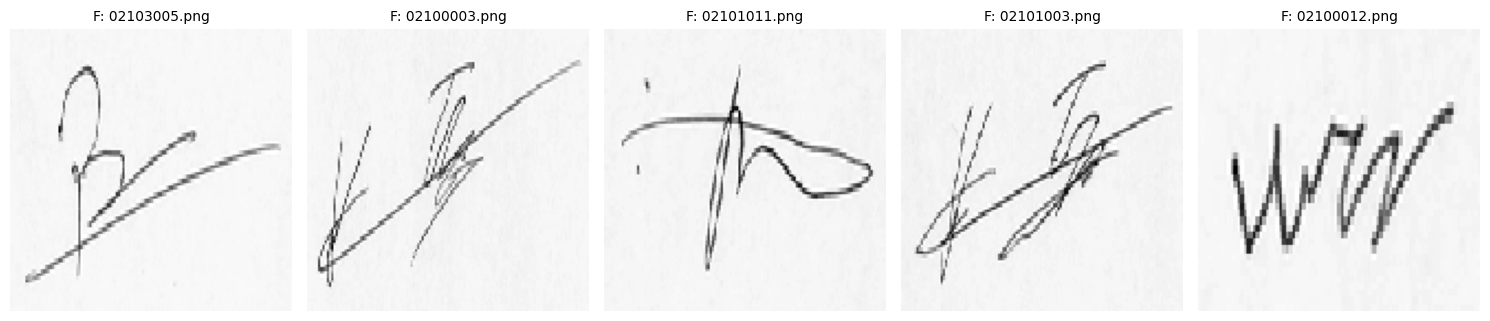

Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2/forge/


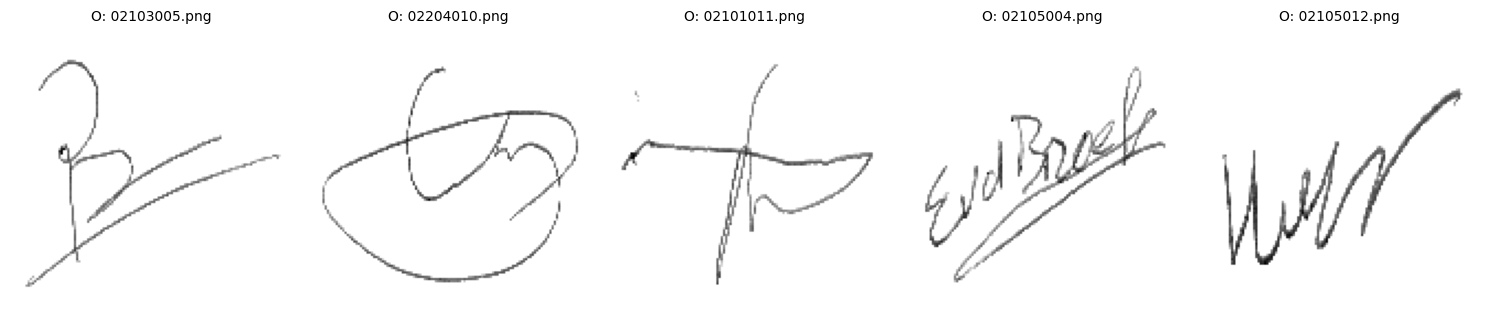

Total images loaded: 120
Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/real/


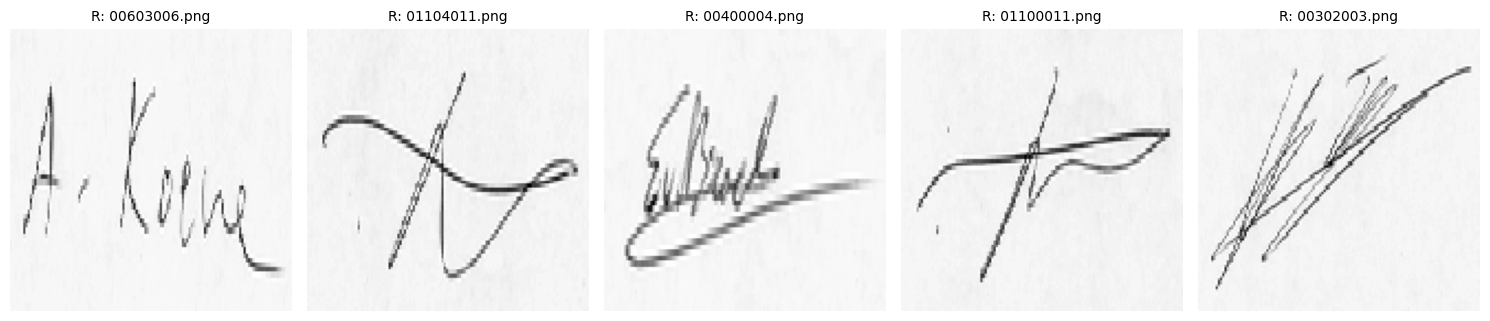

Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2/real/


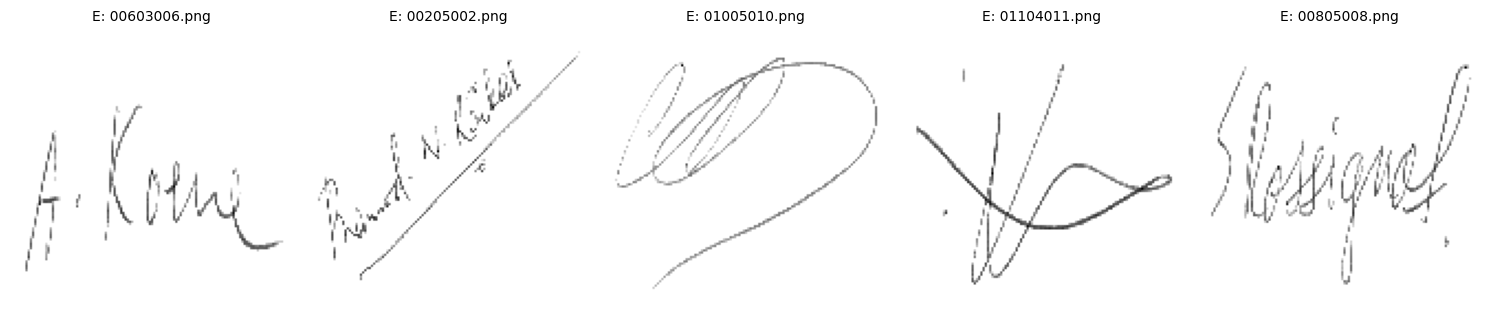

Total images loaded: 120


In [8]:
forged_imgs, forged_label = load_images1(forged_list,"forged")
real_imgs, real_label = load_images1(real_list,"real")

Loading images from subfolders of: /kaggle/input/handwritten-signature-verification/data/data/forged
Error processing file /kaggle/input/handwritten-signature-verification/data/data/forged/ru.d1c664d6-431d-4985-9e21-5989b1b7df4b__0001e12109--61ff34f8f73c4b173c32986d__JP A.jpg: cannot identify image file <_io.BytesIO object at 0x7c56298af880>


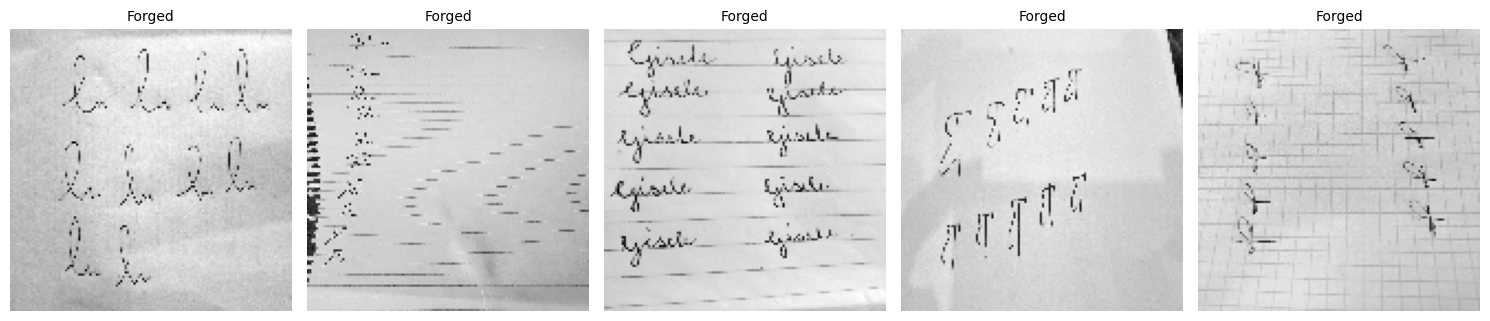

Total images loaded: 2983
Loading images from subfolders of: /kaggle/input/handwritten-signature-verification/data/data/real


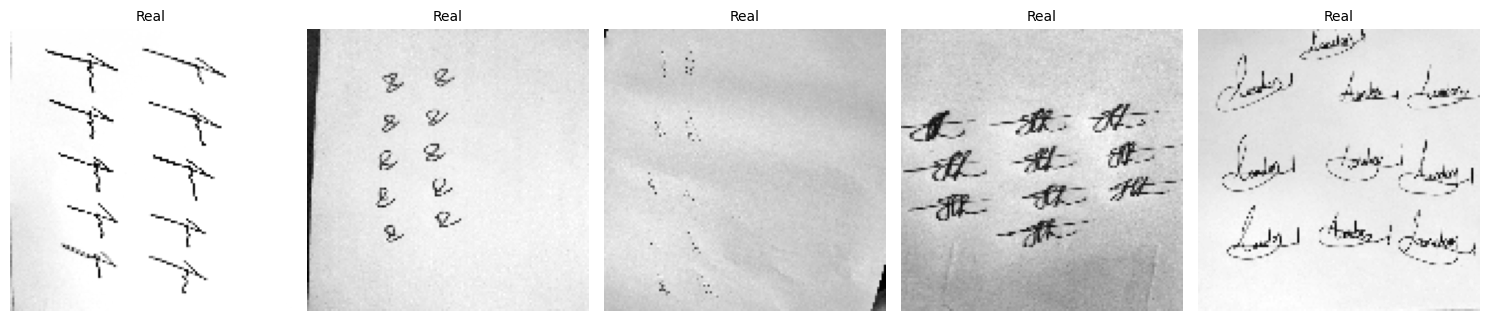

Total images loaded: 3188


In [9]:
imgs_f, labels_f, k = load_images2(f_data, "forged")
imgs_r, labels_r, l = load_images2(r_data, "real")

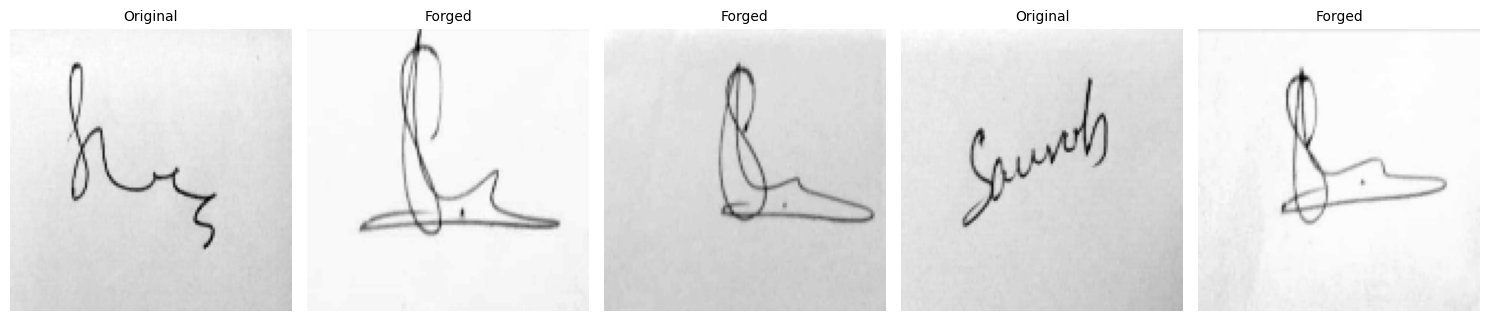

In [12]:
imgs, labels = load_images3(base_folder_path)

# Take Sample

**Shuffling:**

* shuffle is used to randomly rearrange the data and labels (all_images and all_labels) while maintaining the pairing between them. This helps reduce bias during model training by ensuring that the model doesn't learn patterns based on the order of the data.

**Resampling:**

* resample is used to adjust the sample size for various datasets.
* This ensures balanced datasets for training purposes.
* The datasets (imgs, imgs_f, and imgs_r) are resampled to 500, 550, and 600 samples, respectively, using random_state=42 for reproducibility.

**Concatenation:**

* Datasets (imgs_f, imgs_r, forged_imgs, real_imgs, imgs) and their respective labels are concatenated using np.concatenate to combine them into unified arrays:
1. all_images: Contains all the combined image data.
1. all_labels: Contains all the combined labels corresponding to the images.

In [13]:
# Size before taking a sample
print(imgs.shape)
print(imgs_f.shape)
print(imgs_r.shape)
print(forged_imgs.shape)
print(real_imgs.shape)

(2293, 128, 128, 1)
(2983, 128, 128, 1)
(3188, 128, 128, 1)
(120, 128, 128, 1)
(120, 128, 128, 1)


In [14]:
imgs, labels = resample(imgs, labels, n_samples=500, random_state=42, replace=False)
imgs_f, labels_f = resample(imgs_f, labels_f, n_samples=550, random_state=42, replace=False)
imgs_r, labels_r= resample(imgs_r, labels_r, n_samples=600, random_state=42, replace=False)

In [15]:
# Size after taking a sample
print(imgs.shape)
print(imgs_f.shape)
print(imgs_r.shape)
print(forged_imgs.shape)
print(real_imgs.shape)
print(labels.shape)
print(labels_f.shape)
print(labels_r.shape)
print(forged_label.shape)
print(real_label.shape)

(500, 128, 128, 1)
(550, 128, 128, 1)
(600, 128, 128, 1)
(120, 128, 128, 1)
(120, 128, 128, 1)
(500,)
(550,)
(600,)
(120,)
(120,)


In [16]:
all_images = np.concatenate((imgs_f, imgs_r,forged_imgs,real_imgs,imgs), axis=0)
all_labels = np.concatenate((labels_f, labels_r,forged_label,real_label,labels), axis=0)

all_images, all_labels = shuffle(all_images, all_labels, random_state=42)

# imgs_f, labels_f = shuffle(imgs_f, labels_f, random_state=42)
# imgs_r, labels_r = shuffle(imgs_r, labels_r, random_state=42)
# forged_imgs, forged_label = shuffle(forged_imgs, forged_label, random_state=42)
# real_imgs, real_label = shuffle(real_imgs, real_label, random_state=42)
# imgs, labels = shuffle(imgs, labels, random_state=42)

# all_images = np.concatenate((imgs_f, imgs_r,forged_imgs,real_imgs,imgs), axis=0)
# all_labels = np.concatenate((labels_f, labels_r,forged_label,real_label,labels), axis=0)

In [17]:
all_labels = to_categorical(all_labels,num_classes = 2)

In [38]:
print(all_images.shape)
print(all_labels.shape)

(1890, 128, 128, 1)
(1890, 2)


In [39]:
x_train, x_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)

Training set shape: (1323, 128, 128, 1)
Validation set shape: (567, 128, 128, 1)


# Bidirectional LSTM Model Train

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)

In [41]:
model_LSTM = Sequential([
    Reshape((128, 128), input_shape=(128, 128, 1)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_LSTM.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,586 (451.51 KB)

 Trainable params: 115,586 (451.51 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
LR = 0.0001
optimizer = Adam(learning_rate=LR)
model_LSTM.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
history = model_LSTM.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 64,
    epochs=100,
    validation_data=(x_val / 255.0, y_val)
)

Epoch 1/96
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.5320 - loss: 0.6927 - val_accuracy: 0.5944 - val_loss: 0.6899
Epoch 2/96
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5581 - loss: 0.6906 - val_accuracy: 0.5944 - val_loss: 0.6898
Epoch 3/96
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.5462 - loss: 0.6912 - val_accuracy: 0.5944 - val_loss: 0.6874
Epoch 4/96
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4375 - loss: 0.6957 - val_accuracy: 0.5944 - val_loss: 0.6874
Epoch 5/96
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5462 - loss: 0.6902 - val_accuracy: 0.5944 - val_loss: 0.6856
Epoch 6/96
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6094 - loss: 0.6835 - val_accuracy: 0.5944 - val_loss: 0.6855
Epoch 7/96
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5398 - loss: 0.6894 - val_accuracy: 0.5944 - val_loss: 0.6829
Epoch 8/96
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5312 - loss: 0.6916 - val_accuracy: 0.5944 - val_l

# Testing

We are testing the entire data across all three datasets to ensure the model is generalized and robust. By combining and shuffling the datasets, the model is exposed to diverse signature variations, improving its ability to perform well across different scenarios and datasets.

In [44]:
print(imgs.shape)
print(imgs_f.shape)
print(imgs_r.shape)
print(forged_imgs.shape)
print(real_imgs.shape)
print(labels.shape)
print(labels_f.shape)
print(labels_r.shape)
print(forged_label.shape)
print(real_label.shape)

(500, 128, 128, 1)
(550, 128, 128, 1)
(600, 128, 128, 1)
(120, 128, 128, 1)
(120, 128, 128, 1)
(500,)
(550,)
(600,)
(120,)
(120,)


In [52]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
if len(all_labels.shape) > 1 and all_labels.shape[1] > 1:  # Check if one-hot encoded
    true_labels = np.argmax(all_labels, axis=1)
else:
    true_labels = all_labels

test_loss, test_accuracy = model_LSTM.evaluate(all_images / 255.0, all_labels)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6812 - loss: 0.5086
Test Loss: 0.515921413898468
Test Accuracy: 0.6873015761375427


In [53]:
predictions = model_LSTM.predict(all_images / 255.0)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.47      0.62      1049
           1       0.59      0.96      0.73       841

    accuracy                           0.69      1890
   macro avg       0.76      0.71      0.68      1890
weighted avg       0.78      0.69      0.67      1890



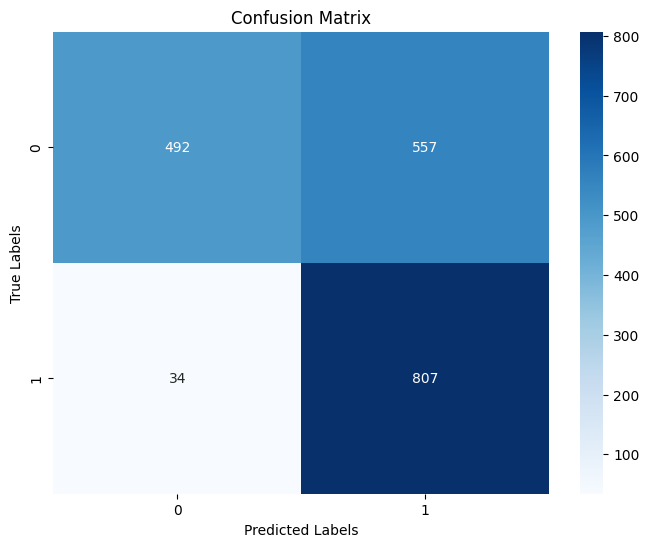

In [54]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
def plot_train(hist):
    history = hist.history

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid()

    if 'accuracy' in history:  # Adjust for older versions with 'acc'
        axes[1].plot(history['accuracy'], label='Training Accuracy')
        axes[1].plot(history['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy Over Epochs')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid()


    plt.tight_layout()
    plt.show()

In [ ]:
plot_train(history)

# Conclusion:

The model achieved a **training accuracy: 0.7031** - **loss: 0.5079** - **val_accuracy: 0.6808** - **val_loss: 0.4751** **test accuracy of 67.02%** with a **test loss of 0.4988**, indicating moderate performance in distinguishing between classes.  Although accuracy improved during training, fluctuations indicate room for optimization. Enhancing the model's performance may require using more consistent and coherent data.